# Fourier transform in python

* signal is of finite length 
* sequence rather than a continous function in frequency

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.io.wavfile

In [3]:
# this is the support in time domain

sample_rate = 10 # samples per sec
total_sampling_time = 3
num_samples = sample_rate * total_sampling_time

print('number of samples:', num_samples)

t = np.linspace(0, total_sampling_time, num_samples)

number of samples: 30


30


[Text(0,0.5,'source signal'), Text(0.5,0,'time (s)')]

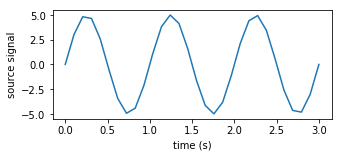

In [4]:
#signal generator and plot within the support

# between x = 0 and x = 1, a complete revolution (2 pi) has been made, so this is
# a 1 Hz signal with an amplitude of 5
frequency_in_hz = 1
wave_amplitude = 5
fun = lambda x: wave_amplitude * np.sin(frequency_in_hz * 2*np.pi*x)
    
signal = [fun(i) for i in t]
print(len(signal))

# plot
fig, ax= plt.subplots(1,1, figsize=(5, 2))
ax.plot(t, signal)
ax.set(xlabel='time (s)', ylabel='source signal')

size of complex fft: 30


[Text(0,0.5,'amplitude'), Text(0.5,0,'FFT bins')]

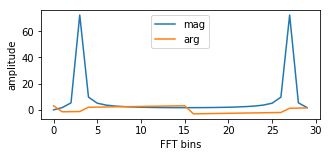

In [5]:
# taking the fft: Compute the one-dimensional discrete Fourier Transform.

fft_output = np.fft.fft(signal)

print('size of complex fft:',len(fft_output))

# plot
fig, ax= plt.subplots(1,1, figsize=(5, 2))
ax.plot(np.abs(fft_output))
ax.plot(np.angle(fft_output))
ax.legend(['mag', 'arg'])
ax.set(xlabel='FFT bins', ylabel='amplitude')

when signal is sampled and truncated, we must consider the windowing effect effect (distortion in the frequency domain) and the scaling factor as compared with the Fourier transform of the original signal.

## The signal is not centered in zero

The zero-frequency is shift to the center in both audio and image spectrums, simply because this is how people normally expect to see a spectrum. I.e. it is per convention. The spectrum content is not change in any way, and everything you can derive after the shift, you can derive before the shift.

## Why is it mirrored?

* Because it is a complex-input fourier transform, and for **real input, the 2nd half will always be a mirror image**.
* For real-valued input, the fft output is always symmetric.
* Since we are only dealing with real input, let's just use a real-input version of the fft.

size of complex fft: 16


[Text(0,0.5,'amplitude'), Text(0.5,0,'FFT bins')]

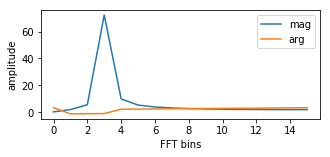

In [6]:
# taking the rfft: Compute the one-dimensional discrete Fourier Transform for real input.
rfft_output = np.fft.rfft(signal)

print('size of complex fft:', len(rfft_output))

# plot
fig, ax= plt.subplots(1,1, figsize=(5, 2))
ax.plot(np.abs(rfft_output))
ax.plot(np.angle(rfft_output))
ax.legend(['mag', 'arg'])
ax.set(xlabel='FFT bins', ylabel='amplitude')

## on the size of rfft

The real FFT in numpy uses the fact that the fourier transform of a real valued function is so to say "skew-symmetric", that is the value at frequency k is the complex conjugate of the value at frequency N-k for k=1..N-1 (the correct term is Hermitian). Therefore rfft returns **only the part of the result that corresponds to nonpositive frequences**.

For an input of size N the rfft function returns the part of the FFT output corresponding to frequences at or below N/2. Therefore the **output of rfft is of size N/2+1 if N is even** (all frequences from 0 to N/2), or (N+1)/2 if N is odd (all frequences from 0 to (N-1)/2). Observe that the function floor(n/2+1) returns the correct output size for both even and odd input sizes.

[Text(0,0.5,'amplitude'), Text(0.5,0,'freq (Hz)')]

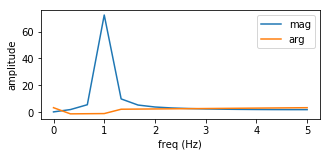

In [7]:
# to correct the x-axis, to represent frequency
freq = [(i*1.0/num_samples)*sample_rate for i in range(num_samples//2+1)]

# plot
fig, ax= plt.subplots(1,1, figsize=(5, 2))
ax.plot(freq,np.abs(rfft_output))
ax.plot(freq,np.angle(rfft_output))
ax.legend(['mag', 'arg'])
ax.set(xlabel='freq (Hz)', ylabel='amplitude')


[Text(0,0.5,'magnitude'), Text(0.5,0,'freq (Hz)')]

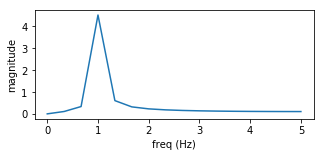

In [8]:
# Getting y-axis labels correct
# We want the y-axis to represent magnitude
# We are actually getting negative values, and it looks like our amplitude is way larger than what it should be (which is 5).

# The magnitude of each component is
rfft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(rfft_output) for i in rfft_output]
# plot
fig, ax= plt.subplots(1,1, figsize=(5, 2))
ax.plot(freq,rfft_mag)
ax.set(xlabel='freq (Hz)', ylabel='magnitude')

[Text(0,0.5,'amplitude'), Text(0.5,0,'IFFT bins')]

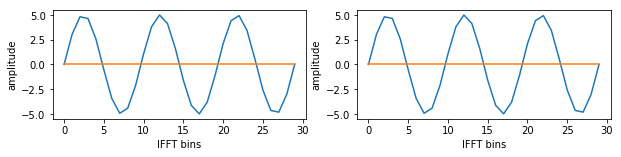

In [9]:
ifft_output = np.fft.ifft(fft_output)
irfft_output = np.fft.irfft(rfft_output)

fig, (ax,ax2) = plt.subplots(1,2, figsize=(10, 2))
ax.plot(np.real(ifft_output))
ax.plot(np.imag(ifft_output))

ax2.plot(np.real(irfft_output))
ax2.plot(np.imag(irfft_output))

ax.set(xlabel='IFFT bins', ylabel='amplitude')
ax2.set(xlabel='IFFT bins', ylabel='amplitude')

## Short-time Fourier Transform (STFT)
Procedure:

* Break audio file into (overlapping) chunks
* Apply a window to each chunk
* Run windowed chunk through the FFT

Meaning:
* take more samples for each FFT, we know more about the frequency
* But since we are taking more samples to represent each "block", the time resolution goes down (since the time block is larger)

FFT Bin Size

$fft_{bin \ size} = \frac{sample \ rate}{window \ size} $
* So the larger the window size, the smaller the fft bin size (better frequency resolution)
* And the smaller the window size, the larger the fft bin size (worse frequency resolution)

[Text(0,0.5,'amplitude'), Text(0.5,0,'time (s)')]

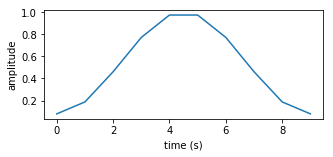

In [10]:
window_size = sample_rate # sample_rate points (which is 1 second in this case)
hop_size = window_size // 2

window = scipy.hamming(window_size)

# plot
fig, ax= plt.subplots(1,1, figsize=(5, 2))
ax.plot(window)
ax.set(xlabel='time (s)', ylabel='amplitude')

[Text(0,0.5,'amplitude'), Text(0.5,0,'time (s)')]

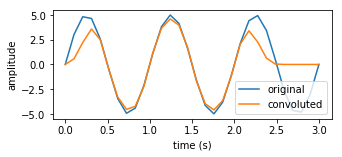

In [11]:
# Break up into chunks and apply window
windowed = [window * signal[i:i+window_size] for i in range(0, len(signal) - window_size, hop_size)]

# Put windowed chunks back together (and compare to original)
convoluted = scipy.zeros(total_sampling_time * sample_rate)

for n,i in enumerate(range(0, len(signal) - window_size, hop_size)):
    convoluted[i:i + window_size] += windowed[n]
    
# plot
fig, ax= plt.subplots(1,1, figsize=(5, 2))
ax.plot(t, signal)
ax.plot(t, convoluted)
ax.legend(['original', 'convoluted'])
ax.set(xlabel='time (s)', ylabel='amplitude')

C:\Users\p0cvgk\AppData\Local\Continuum\miniconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[Text(0,0.5,'amplitude'), Text(0.5,0,'bins')]

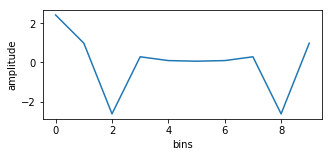

In [12]:
def stft(input_data, sample_rate, window_size, hop_size):
    window = scipy.hamming(window_size)
    output = scipy.array([scipy.fft(window*input_data[i:i+window_size]) 
                         for i in range(0, len(input_data)-window_size, hop_size)])
    return output

stft_output = stft(signal, sample_rate, window_size, hop_size)

# plot
fig, ax= plt.subplots(1,1, figsize=(5, 2))
ax.plot(stft_output[0])
# ax.plot(np.angle(stft_output))
# ax.legend(['real', 'imag'])
ax.set(xlabel='bins', ylabel='amplitude')

The DFT of a real signal is symmetric around the folding frequency. Since
there is no additional information past this point, we can save time by eval-
uating only the ﬁrst half of the DFT, and that’s exactly what np.fft.rfft
does

DFT is a Fourier representation of a ﬁnite length sequence and is itself a sequence rather than a continuous function of frequency, and it corresponds to samples, equally spaced in frequency, of the Fourier transform of the signal

# DFT of a sampled truncated sequence: Truncated exact number of periods

[2. +0.j         2. +7.78231365j 2.-10.62497697j 2. -3.80422607j
 2. -2.17727949j 2. -1.32316908j 2. -0.72654253j 2. -0.23267212j
 2. +0.23267212j 2. +0.72654253j 2. +1.32316908j 2. +2.17727949j
 2. +3.80422607j 2.+10.62497697j 2. -7.78231365j]


[Text(0,0.5,'$|X_1| scaled$'), Text(0.5,0,'freq (Hz)')]

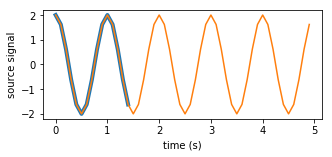

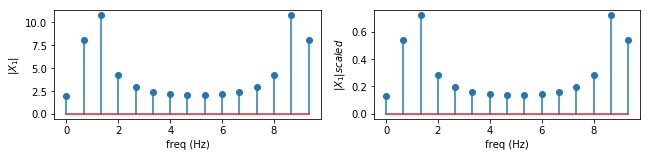

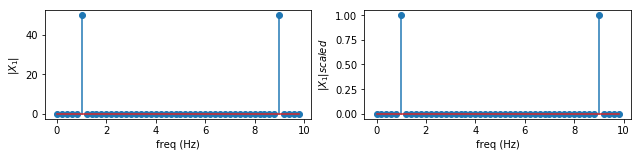

In [13]:
frequency_in_hz = 1 # p in the book, this is the signal frequency
wave_amplitude = 2
sample_period = 1/frequency_in_hz
sample_rate = 10/sample_period # samples per sec

# truncated data number of period
T1 = 1.5*sample_period # 10 points DFT
T2 = 5*sample_period # 50 points DFT

t1 = np.arange(0, T1, 1/sample_rate)
t2 = np.arange(0, T2, 1/sample_rate)
fun = lambda x: wave_amplitude * np.cos(frequency_in_hz * 2*np.pi * x)
    
x1 = [fun(i) for i in t1]
x2 = [fun(i) for i in t2]

# perform the dft of each signal
X1 = np.fft.fft(x1)
X2 = np.fft.fft(x2)

N1 = len(x1)
N2 = len(x2)
f1 = sample_rate * np.arange(0,N1) / N1
f2 = sample_rate * np.arange(0,N2) / N2
print(X1)

# plot
fig, ax= plt.subplots(1,1, figsize=(5, 2))
ax.plot(t1, x1, lw='4')
ax.plot(t2, x2)
ax.set(xlabel='time (s)', ylabel='source signal')

fig, (ax,ax2)= plt.subplots(1,2, figsize=(10.5, 2))
ax.stem(f1, np.abs(X1))
ax.set(xlabel='freq (Hz)', ylabel='$|X_1|$')
ax2.stem(f1, np.abs(X1)/sample_rate/T1)
ax2.set(xlabel='freq (Hz)', ylabel='$|X_1| scaled$')

fig, (ax,ax2)= plt.subplots(1,2, figsize=(10.5, 2))
ax.stem(f2, np.abs(X2))
ax.set(xlabel='freq (Hz)', ylabel='$|X_1|$')
ax2.stem(f2, np.abs(X2)/sample_rate/T2)
ax2.set(xlabel='freq (Hz)', ylabel='$|X_1| scaled$')


Plot the results (modulus) of 10-point DFT.

Note the frequency range 0 to 9 Hz ( fs − fs /N) and the peak amplitude AT /2*Delta = 5A = 10

Since **exact number of period** is taken for DFT, all the frequency components except p = 1 Hz (and 9 Hz, which is the mirror image of p Hz)
are zero.

Plot the results (modulus) of 50-point DFT.

In this case, we used the data ﬁve times longer in ‘time’ than in the previous case. This results in an **increase of frequency resolution**, i.e. the resolution is increased ﬁve times that in the previous case.

Since the DFT has a periodic structure, X(10) (if it is evaluated) will be equal to X(0).
Also, due to the symmetry property of the magnitude spectrum of X(k), the right half of the ﬁgure is the mirror image of the left half.

# DFT of a sampled truncated sequence: Truncated non-exact number of periods

signiﬁcant amount of smearing and leakage due to windowing

35


[Text(0,0.5,'$|X_1| scaled$'), Text(0.5,0,'freq (Hz)')]

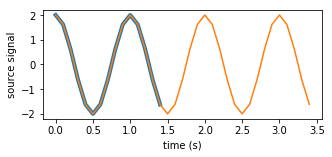

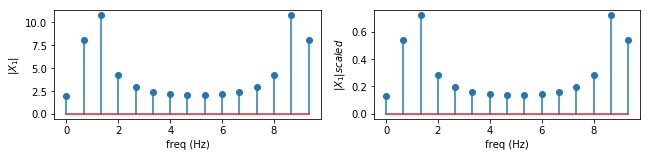

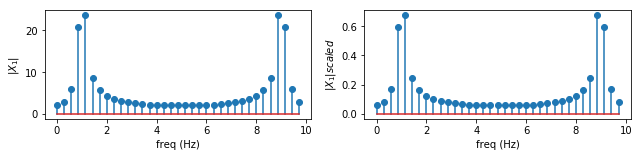

In [14]:
frequency_in_hz = 1 # p in the book, this is the signal frequency
wave_amplitude = 2
sample_period = 1/frequency_in_hz
sample_rate = 10/sample_period # samples per sec

# truncated data number of period
T1 = 1.5*sample_period # 15 points DFT
T2 = 3.5*sample_period # 35 points DFT

t1 = np.arange(0, T1, 1/sample_rate)
t2 = np.arange(0, T2, 1/sample_rate)
fun = lambda x: wave_amplitude * np.cos(frequency_in_hz * 2*np.pi * x)
    
x1 = [fun(i) for i in t1]
x2 = [fun(i) for i in t2]

# perform the dft of each signal
X1 = np.fft.fft(x1)
X2 = np.fft.fft(x2)

N1 = len(x1)
N2 = len(x2)
f1 = sample_rate * np.arange(0,N1) / N1
f2 = sample_rate * np.arange(0,N2) / N2
print(len(f2))

# plot
fig, ax= plt.subplots(1,1, figsize=(5, 2))
ax.plot(t1, x1, lw='4')
ax.plot(t2, x2)
ax.set(xlabel='time (s)', ylabel='source signal')

fig, (ax,ax2)= plt.subplots(1,2, figsize=(10.5, 2))
ax.stem(f1, np.abs(X1))
ax.set(xlabel='freq (Hz)', ylabel='$|X_1|$')
ax2.stem(f1, np.abs(X1)/sample_rate/T1)
ax2.set(xlabel='freq (Hz)', ylabel='$|X_1| scaled$')

fig, (ax,ax2)= plt.subplots(1,2, figsize=(10.5, 2))
ax.stem(f2, np.abs(X2))
ax.set(xlabel='freq (Hz)', ylabel='$|X_1|$')
ax2.stem(f2, np.abs(X2)/sample_rate/T2)
ax2.set(xlabel='freq (Hz)', ylabel='$|X_1| scaled$')

## if increased the sampling rate: twice the prevous used
Recall that the only way of increasing frequency resolution is by increasing data
length (in time). Note that, since the sampling rate is doubled, double the amount of data
is needed over the previous example in order to get the same frequency resolution.

[ 1.99159850e-16+0.00000000e+00j  2.00000000e+01-5.81892924e-15j
  8.26249683e-16+1.00603272e-15j  4.44089210e-15+4.93075082e-15j
 -1.59721874e-15-8.82791504e-16j  2.81419452e-15+5.20002601e-16j
  3.29742852e-16-1.20544120e-15j -3.55271368e-15+4.25472732e-15j
  8.85315414e-16+2.37279877e-15j -3.03607882e-16+1.84819824e-15j
 -1.08733827e-15+0.00000000e+00j  3.55271368e-15+4.00579065e-15j
  8.85315414e-16-2.37279877e-15j  3.03607882e-16+1.32614007e-15j
  3.29742852e-16+1.20544120e-15j -3.55271368e-15+4.68361735e-15j
 -1.59721874e-15+8.82791504e-16j -2.81419452e-15-3.24705273e-16j
  8.26249683e-16-1.00603272e-15j  2.00000000e+01-1.54255925e-14j]


[Text(0,0.5,'$|X_1| scaled$'), Text(0.5,0,'freq (Hz)')]

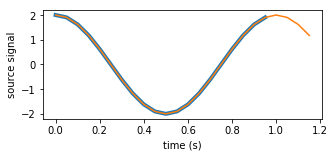

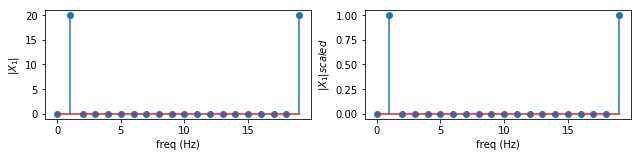

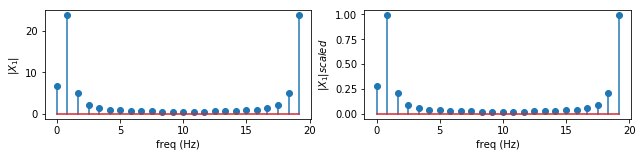

In [18]:
frequency_in_hz = 1 # p in the book, this is the signal frequency
wave_amplitude = 2
sample_period = 1/frequency_in_hz
sample_rate = 20/sample_period # samples per sec

# truncated data number of period
T1 = 1*sample_period # 20 points DFT
T2 = 1.2*sample_period # 30 points DFT

t1 = np.arange(0, T1, 1/sample_rate)
t2 = np.arange(0, T2, 1/sample_rate)
fun = lambda x: wave_amplitude * np.cos(frequency_in_hz * 2*np.pi * x)
    
x1 = [fun(i) for i in t1]
x2 = [fun(i) for i in t2]

# perform the dft of each signal
X1 = np.fft.fft(x1)
X2 = np.fft.fft(x2)

N1 = len(x1)
N2 = len(x2)
f1 = sample_rate * np.arange(0,N1) / N1
f2 = sample_rate * np.arange(0,N2) / N2
print(X1)

# plot
fig, ax= plt.subplots(1,1, figsize=(5, 2))
ax.plot(t1, x1, lw='4')
ax.plot(t2, x2)
ax.set(xlabel='time (s)', ylabel='source signal')

fig, (ax,ax2)= plt.subplots(1,2, figsize=(10.5, 2))
ax.stem(f1, np.abs(X1))
ax.set(xlabel='freq (Hz)', ylabel='$|X_1|$')
ax2.stem(f1, np.abs(X1)/sample_rate/T1)
ax2.set(xlabel='freq (Hz)', ylabel='$|X_1| scaled$')

fig, (ax,ax2)= plt.subplots(1,2, figsize=(10.5, 2))
ax.stem(f2, np.abs(X2))
ax.set(xlabel='freq (Hz)', ylabel='$|X_1|$')
ax2.stem(f2, np.abs(X2)/sample_rate/T2)
ax2.set(xlabel='freq (Hz)', ylabel='$|X_1| scaled$')

# Symmetry properties of DFT
discrete Fourier transform (DFT) converts a finite sequence of equally-spaced samples of a function into a same-length sequence of equally-spaced samples of the discrete-time Fourier transform (DTFT), which is a **complex-valued function of frequency**

[Text(0,0.5,'$arg |X_2|$'), Text(0.5,0,'freq (Hz)')]

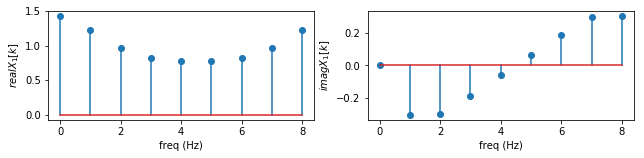

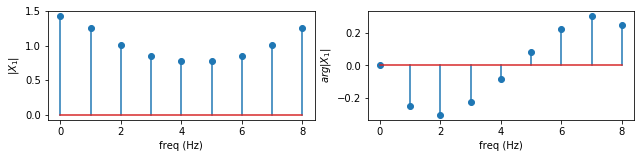

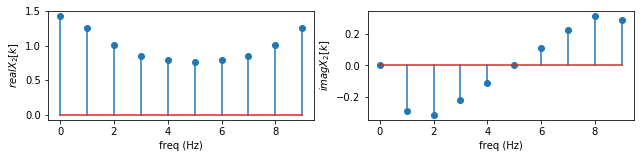

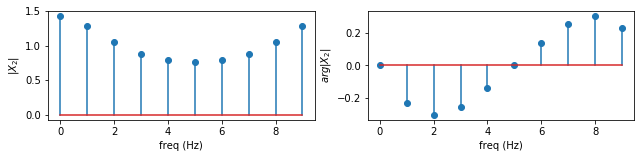

In [16]:
a = .3
n1 = np.arange(0,9) # 9 point sequence
n2 = np.arange(0,10) # 10 points sequence

# generate two sequences
x1 = a**n1
x2 = a**n2

# Perform the DFT of each sequence, i.e.
X1 = np.fft.fft(x1)
X2 = np.fft.fft(x2)

fig, (ax,ax2)= plt.subplots(1,2, figsize=(10.5, 2))
ax.stem(n1, np.real(X1))
ax.set(xlabel='freq (Hz)', ylabel='$real X_1[k]$')
ax2.stem(n1, np.imag(X1))
ax2.set(xlabel='freq (Hz)', ylabel='$imag X_1[k]$')

fig, (ax,ax2)= plt.subplots(1,2, figsize=(10.5, 2))
ax.stem(n1, np.abs(X1))
ax.set(xlabel='freq (Hz)', ylabel='$|X_1|$')
ax2.stem(n1, np.angle(X1))
ax2.set(xlabel='freq (Hz)', ylabel='$arg |X_1|$')

fig, (ax,ax2)= plt.subplots(1,2, figsize=(10.5, 2))
ax.stem(n2, np.real(X2))
ax.set(xlabel='freq (Hz)', ylabel='$real X_2[k]$')
ax2.stem(n2, np.imag(X2))
ax2.set(xlabel='freq (Hz)', ylabel='$imag X_2[k]$')

fig, (ax,ax2)= plt.subplots(1,2, figsize=(10.5, 2))
ax.stem(n2, np.abs(X2))
ax.set(xlabel='freq (Hz)', ylabel='$|X_2|$')
ax2.stem(n2, np.angle(X2))
ax2.set(xlabel='freq (Hz)', ylabel='$arg |X_2|$')

The act of deﬁning the time variable ‘t=[0:1/fs:T-1/fs];’ is the ‘sampling’ of the analogue signal x(t). Since we cannot (in a
simple way in computer programming) apply the low-passﬁlter before the sampling, we
always have to face the aliasing problem in computer simulations. Note that aliasing does
occur even if the signal is obtained by solving the corresponding ordinary differential
equation using a numerical integration method such as the Runge–Kutta method. Thus,
we may use a much higher sampling rate to minimize the aliasing problem, but we cannot
avoid it completely.

(-1.3858304524969697e-14+0j)
(-3.783912185687308e-14+0j)


[Text(0,0.5,'$arg |X|$'), Text(0.5,0,'freq (Hz)')]

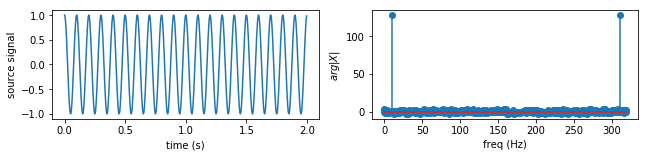

In [17]:
# this is the support in time domain

frequency_in_hz = 10 # p in the book, this is the signal frequency
wave_amplitude = 1
sample_period = 1/frequency_in_hz 
sample_rate = 32/sample_period # samples per sec

# truncated data number of period 
T = 2 * frequency_in_hz * sample_period #  2 seconds

t = np.arange(0, T, 1/sample_rate)

#signal generator and plot within the support
fun = lambda x: wave_amplitude * np.cos(frequency_in_hz * 2 * np.pi * x)
    
signal = [fun(i) for i in t]

# Lets consider taking a (N=256) point FFT, which is the (8^{th}) power of (2).
N = 256
X = np.fft.fft(signal,N)
# output contains DC at index 1, Nyquist frequency at N/2+1 th index
print(X[0])
# positive frequencies from index 2 to N/2
print(X[N//2])
# negative frequencies from index N/2+1 to N

# calculate frequency bins with FFT
freq = sample_rate * np.arange(0,N) / N

# plot
fig, (ax,ax2)= plt.subplots(1,2, figsize=(10.5, 2))
ax.plot(t, signal)
ax.set(xlabel='time (s)', ylabel='source signal')
ax2.stem(freq, np.abs(X))
ax2.set(xlabel='freq (Hz)', ylabel='$|X|$')
ax2.stem(freq, np.angle(X))
ax2.set(xlabel='freq (Hz)', ylabel='$arg |X|$')

The FFT length should be sufficient to cover the entire length of the input signal. If N is less than the length of the input signal, the input signal will be truncated when computing the FFT. In our case, the cosine wave is of 2 seconds duration and it will have **640 points** (a 10Hz frequency wave sampled at 32 times oversampling factor will have 2×32×10=640 samples in 2 seconds of the record). Since our input signal is periodic, we can safely use N=256 point FFT, anyways the FFT will extend the signal when computing the FFT (see additional topic on spectral leakage that explains this extension concept).

we note that the cosine signal has registered a spike at 10Hz. In addition to that, it has also registered a spike at 256−8=248th sample that belongs to negative frequency portion. Since we know the nature of the signal, we can optionally ignore the negative frequencies. The sample at the Nyquist frequency (fs/2) mark the boundary between the positive and negative frequencies.

Note that the complex numbers surrounding the Nyquist index are complex conjugates and they represent positive and negative frequencies respectively.

When you take an FFT of real values, you get something else: conjugate symmetry. If you want an IFFT output with only real values, the IFFT input must exhibit conjugate symmetry.     

In the complex spectrum required to do a reconstruction IFFT. Both components are required, otherwise you've thrown away half the information about your signal, and can't reconstruct it **unless the original signal was purely symmetric or purely anti-symmetric to begin with).**

When you fft() N points, **you get out N points**. If the original N points were all **real-valued**, then the N output points of fft() will be in **two halves that will be complex conjugates of each other** (and reversed left-to-right). **Except, that is, for the first output point, which does not get included in this conj(fliplr(X))**. If you know the first output value, and you know the first half segment of the output, and you know the original data was real, then you can reconstruct the complex conjugate portion prior to taking the ifft() -- **but you need that complex conjugate portion to be there in order for the ifft() to function properly.**

If any of the original N points were complex-valued, then you need all N points of the fft() output, as the fft() in such a case is not conjugate-symmetric.

ifft() cannot simply be applied to "the first half" of the fft() output in order to regenerate the original data, as it would not be able to distinguish that case from the case of being asked to take the inverse fft of data that was originally complex.